<a href="https://colab.research.google.com/github/skamranh/big-data-final/blob/main/CHD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference
- https://www.kaggle.com/code/wassimchouchen/principal-component-analysis

In [2]:
!pip install pyspark
!pip install -q findspark

import pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
import pyspark.pandas as ps

spark = SparkSession.builder.appName('wine').getOrCreate()

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 50.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=dd7daf4b2fd3e0b7fa7f45a981035c6e0d20bde3390fef29c8013c175204e24b
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [3]:
dataset_loc = "/content/drive/MyDrive/Dataset/chd.csv"
chd_spark = spark.read.csv(dataset_loc, header="true")
chd_pd = pd.read_csv(dataset_loc)
chd_ps = ps.read_csv(dataset_loc)

In [5]:
chd_ps.head()

,Year,LocationAbbr,LocationDesc,Datasource,PriorityArea1,PriorityArea2,PriorityArea3,PriorityArea4,Category,Topic,Indicator,Data_Value_Type,Data_Value_Unit,Data_Value,Data_Value_Alt,Data_Value_Footnote_Symbol,Data_Value_Footnote,Confidence_Limit_Low,Confidence_Limit_High,Break_Out_Category,Break_out,CategoryID,TopicID,IndicatorID,Data_Value_TypeID,BreakoutCategoryID,BreakOutID,LocationID,GeoLocation
0,2011,AL,Alabama,BRFSS,None,None,None,None,Cardiovascular Diseases,Major Cardiovascular Disease,Prevalence of major cardiovascular disease amo...,Age-Standardized,Percent (%),9.9,9.9,None,None,9.2,10.7,Overall,Overall,C1,T1,BR001,AgeStdz,BOC01,OVR01,1,"(32.84057112200048, -86.63186076199969)"
1,2011,AL,Alabama,BRFSS,None,None,None,None,Cardiovascular Diseases,Major Cardiovascular Disease,Prevalence of major cardiovascular disease amo...,Crude,Percent (%),11.0,11.0,None,None,10.2,11.9,Overall,Overall,C1,T1,BR001,Crude,BOC01,OVR01,1,"(32.84057112200048, -86.63186076199969)"
2,2011,AL,Alabama,BRFSS,None,None,None,None,Cardiovascular Diseases,Major Cardiovascular Disease,Prevalence of major cardiovascular disease amo...,Crude,Percent (%),12.5,12.5,None,None,11.1,14.0,Gender,Male,C1,T1,BR001,Crude,BOC02,GEN01,1,"(32.84057112200048, -86.63186076199969)"
3,2011,AL,Alabama,BRFSS,None,None,None,None,Cardiovascular Diseases,Major Cardiovascular Disease,Prevalence of major cardiovascular disease amo...,Age-Standardized,Percent (%),11.8,11.8,None,None,10.6,13.2,Gender,Male,C1,T1,BR001,AgeStdz,BOC02,GEN01,1,"(32.84057112200048, -86.63186076199969)"
4,2011,AL,Alabama,BRFSS,None,None,None,None,Cardiovascular Diseases,Major Cardiovascular Disease,Prevalence of major cardiovascular disease amo...,Age-Standardized,Percent (%),8.3,8.3,None,None,7.5,9.1,Gender,Female,C1,T1,BR001,AgeStdz,BOC02,GEN02,1,"(32.84057112200048, -86.63186076199969)"


In [4]:
chd_ps.describe()

,Year,Data_Value,Data_Value_Alt,Confidence_Limit_Low,Confidence_Limit_High,LocationID
count,85800.000000,57032.000000,85800.000000,55633.000000,55633.000000,85800.000000
mean,2013.000000,33.555527,21.780837,30.503187,36.873832,29.519231
std,1.414222,28.750550,28.712095,27.946300,29.497116,16.029502
min,2011.000000,0.100000,-2.000000,0.200000,0.600000,1.000000
25%,2012.000000,8.700000,-1.000000,7.200000,10.400000,16.000000
50%,2013.000000,26.400000,8.600000,22.300000,30.100000,29.000000
75%,2014.000000,52.400000,33.300000,44.400000,60.200000,42.000000
max,2015.000000,99.400000,99.400000,99.000000,99.700000,58.000000


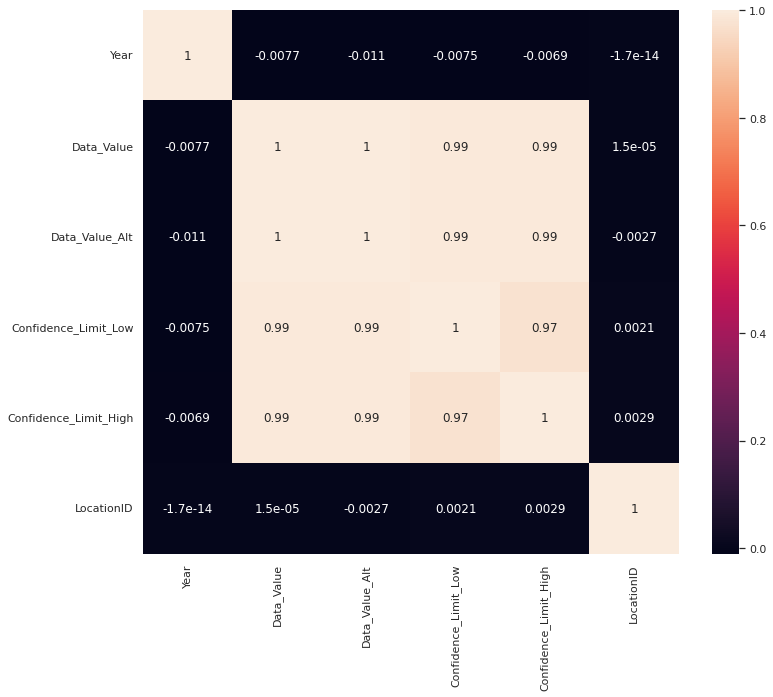

In [6]:
plt.rcParams['figure.figsize'] = [12, 10]
sns.set(font_scale = 1)
sns.heatmap(chd_pd.corr(), annot = True)